<a href="https://colab.research.google.com/github/DhekerKacem/Proof_Of_Concept/blob/main/proof_of_concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Développez une preuve de concept

In [1]:
pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [2]:
pip install transformers

In [4]:
pip install imgaug

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun  9 15:54:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   63C    P8              14W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2
import random
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from PIL import Image
from transformers import SegformerFeatureExtractor
from transformers import TrainingArguments, Trainer
from datasets import load_metric
import torch
from torch.utils.data import Dataset
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import load_metric
import torch.nn.functional as F

### Définition de la métrique personnalisée

La métrique retenue pour le présent projet est « Intersection Over Union » (IoU). Cette métrique est utilisée essentiellement dans des tâches de segmentation d’image, celle-ci sert à évaluer la similitude entre deux ensembles. Plus précisément, cette métrique mesure la similitude spatiale entre les prédictions et les étiquettes réelles. Elle prend en compte aussi bien les pixels correctement prédits que ceux mal prédits.
Contrairement à l’accuracy, l’IoU prend en compte les faux positifs et les faux négatifs ce qui la rend très robuste et davantage informative pour évaluer les performances de modèles de segmentation sémantique surtout dans un contexte de déséquilibre de classe ce qui est le cas de nos données pour le présent projet.
Cette métrique que j’ai nommée ‘CustomMeanIoU’ a été sérialisée afin qu’elle soit sauvegardée avec le modèle et pour que celui-ci puisse être chargé et réutilisé sans problèmes.

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
import keras

# Enregistre la classe comme sérialisable pour Keras.
@keras.saving.register_keras_serializable(package="MyMetrics")
class CustomMeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes=8, name='mean_iou', **kwargs):
        # Appelle le constructeur de la classe parente (Metric) avec le nom et les arguments supplémentaires.
        super(CustomMeanIoU, self).__init__(name=name, **kwargs)
        # Définit le nombre de classes à évaluer.
        self.num_classes = num_classes
        # Initialise un poids pour accumuler la somme des IoU.
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        # Initialise un poids pour compter le nombre de classes valides.
        self.count_classes = self.add_weight(name='count_classes', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Si les tenseurs ont 4 dimensions, applique tf.argmax pour obtenir les labels de classes.
        if len(y_true.shape) == 4:
            y_true = tf.argmax(y_true, axis=-1)
            y_pred = tf.argmax(y_pred, axis=-1)

        # Initialise les variables pour la somme des IoU et le nombre de classes valides.
        mean_iou = 0.0
        class_count = 0.0

        # Boucle sur chaque classe pour calculer l'IoU.
        for i in range(self.num_classes):
            # Crée des masques pour les pixels de la classe i dans les vérités terrain et les prédictions.
            true_class = tf.cast(tf.equal(y_true, i), dtype=tf.float32)
            pred_class = tf.cast(tf.equal(y_pred, i), dtype=tf.float32)

            # Calcule l'intersection des prédictions et des vérités terrain.
            intersection = tf.reduce_sum(true_class * pred_class)
            # Calcule l'union des prédictions et des vérités terrain.
            union = tf.reduce_sum(true_class) + tf.reduce_sum(pred_class) - intersection

            # Calcule l'IoU pour la classe i.
            iou = intersection / (union + K.epsilon())
            # Vérifie si l'union est nulle (pour éviter la division par zéro).
            condition = tf.equal(union, 0)
            # Ajoute l'IoU calculé à la somme des IoU, sauf si l'union est nulle.
            mean_iou = tf.where(condition, mean_iou, mean_iou + iou)
            # Incrémente le compteur de classes valides sauf si l'union est nulle.
            class_count = tf.where(condition, class_count, class_count + 1)

        # Met à jour les poids totaux avec la somme des IoU et le nombre de classes valides.
        self.total_iou.assign_add(mean_iou)
        self.count_classes.assign_add(class_count)

    def result(self):
        # Retourne l'IoU moyen en divisant la somme des IoU par le nombre de classes valides.
        return self.total_iou / (self.count_classes + K.epsilon())

    def reset_state(self):
        # Réinitialise les poids total_iou et count_classes à zéro pour une nouvelle époque.
        self.total_iou.assign(0.0)
        self.count_classes.assign(0.0)

    def get_config(self):
        # Récupère la configuration de la classe parente.
        config = super(CustomMeanIoU, self).get_config()
        # Ajoute le nombre de classes à la configuration.
        config.update({
            'num_classes': self.num_classes,
        })
        # Retourne la configuration mise à jour.
        return config

    @classmethod
    def from_config(cls, config):
        # Crée une instance de la classe à partir de la configuration.
        return cls(**config)

#### Générateur de données

Un data generator est une fonction en machine learning qui génère des lots ou batches de données de façon itérative et sur demande. Il est utilisé lors de l’entrainement de modèles et particulièrement lorsque l’on est en présence d’un grand volume de données ce qui pourrait poser nombre de contraintes au niveau de la mémoire. Le data generator génère des échantillons de données avec leur étiquettes (labels) sans passer par le stockage sur le RAM. Il permet en outre une gestion à la volée en ce sens où il permet de réaliser des opérations de prétraitement en temps réel telles que notamment l’augmentation des images.
Pour les besoins du projet, nous avons créé deux générateurs de données. Le premier sert à charger et préparer des lots d’images et de masques. Pour ce faire, ce générateur incorpore une fonction pour récupérer les chemins d’images et de masques à partir de répertoires définis. Cela nous permet de générer des données d’entrainement, de validation et de test.
Un deuxième générateur qui reproduit le même schéma mais incorpore, en plus, une fonction pour augmenter les images en appliquant un certain nombre de transformations telles que la rotation aléatoire, l’ajustement du contraste gamma ou l’ajout de bruit gaussien.
Le but derrière l’augmentation c’est d’avoir plus de données pour l’entrainement et ce afin d’améliorer l’apprentissage de notre modèle de segmentation sémantique.
Nos modèles seront, ainsi, entrainés à deux reprises, une première sans augmentation et une deuxième avec augmentation.

#### Générateur sans augmentation

In [ ]:
class DataLoadGeneratorSA(Sequence):
    CATS = {
        'void': [0, 1, 2, 3, 4, 5, 6],
        'flat': [7, 8, 9, 10],
        'construction': [11, 12, 13, 14, 15, 16],
        'object': [17, 18, 19, 20],
        'nature': [21, 22],
        'sky': [23],
        'human': [24, 25],
        'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
    }

    def __init__(self, image_paths, mask_paths, crop_x, crop_y, batch_size, shuffle=True):

        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.crop_x = crop_x
        self.crop_y = crop_y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        x, y = self._prepare_data(batch_x, batch_y)
        return x, y

    def _prepare_data(self, image_paths, mask_paths):
        x = []
        y = []
        for img_path, mask_path in zip(image_paths, mask_paths):
            img, mask = self._get_image_and_mask(img_path, mask_path)
            x.append(img)
            y.append(mask)
        x = np.array(x, dtype=np.float32) / 255.0
        y = np.array(y, dtype=np.uint8)
        y = np.expand_dims(y, axis=-1)
        y = to_categorical(y, num_classes=8)
        return x, y

    def _get_image_and_mask(self, img_path, mask_path):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.crop_x, self.crop_y))
        mask = cv2.resize(mask, (self.crop_x, self.crop_y), interpolation=cv2.INTER_NEAREST)
        mask = self._convert_mask(mask)
        return img, mask

    def _convert_mask(self, img):
        mask = np.zeros((img.shape[0], img.shape[1], 8), dtype=np.uint8)
        for i in range(-1, 34):
            if i in self.CATS['void']:
                mask[:, :, 0] = np.logical_or(mask[:, :, 0], (img == i))
            elif i in self.CATS['flat']:
                mask[:, :, 1] = np.logical_or(mask[:, :, 1], (img == i))
            elif i in self.CATS['construction']:
                mask[:, :, 2] = np.logical_or(mask[:, :, 2], (img == i))
            elif i in self.CATS['object']:
                mask[:, :, 3] = np.logical_or(mask[:, :, 3], (img == i))
            elif i in self.CATS['nature']:
                mask[:, :, 4] = np.logical_or(mask[:, :, 4], (img == i))
            elif i in self.CATS['sky']:
                mask[:, :, 5] = np.logical_or(mask[:, :, 5], (img == i))
            elif i in self.CATS['human']:
                mask[:, :, 6] = np.logical_or(mask[:, :, 6], (img == i))
            elif i in self.CATS['vehicle']:
                mask[:, :, 7] = np.logical_or(mask[:, :, 7], (img == i))
        return np.argmax(mask, axis=2).astype('uint8')

# Fonction pour obtenir les chemins des images et des masques
def get_image_and_mask_paths(image_base_dir, mask_base_dir):
    cities = os.listdir(image_base_dir)
    image_paths = []
    mask_paths = []
    for city in cities:
        city_image_dir = os.path.join(image_base_dir, city)
        city_mask_dir = os.path.join(mask_base_dir, city)
        images = os.listdir(city_image_dir)
        for img in images:
            mask = img.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
            mask_path = os.path.join(city_mask_dir, mask)
            if os.path.exists(mask_path):
                image_paths.append(os.path.join(city_image_dir, img))
                mask_paths.append(mask_path)
            else:
                print(f"Mask not found for image: {img}")
    print(f"Total images loaded from {image_base_dir}: {len(image_paths)}")
    print(f"Total masks loaded from {mask_base_dir}: {len(mask_paths)}")
    return image_paths, mask_paths

# Obtenir les chemins pour l'entraînement
train_image_base_dir = '/content/drive/My Drive//data/leftImg8bit/train'
train_mask_base_dir = '/content/drive/My Drive//data/gtFine/train'
train_image_paths, train_mask_paths = get_image_and_mask_paths(train_image_base_dir, train_mask_base_dir)

# Obtenir les chemins pour la validation
val_image_base_dir = '/content/drive/My Drive//data/leftImg8bit/val'
val_mask_base_dir = '/content/drive/My Drive//data/gtFine/val'
val_image_paths, val_mask_paths = get_image_and_mask_paths(val_image_base_dir, val_mask_base_dir)

# Obtenir les chemins pour le test
test_image_base_dir = '/content/drive/My Drive/data/leftImg8bit/test'
test_mask_base_dir = '/content/drive/My Drive//data/gtFine/test'
test_image_paths, test_mask_paths = get_image_and_mask_paths(test_image_base_dir, test_mask_base_dir)

# Création des DataLoaders sans augmentation
train_loaderSA = DataLoadGeneratorSA(train_image_paths, train_mask_paths, crop_x=512, crop_y=512, batch_size=8, shuffle=True)
val_loaderSA = DataLoadGeneratorSA(val_image_paths, val_mask_paths, crop_x=512, crop_y=512, batch_size=8, shuffle=False)
test_loaderSA = DataLoadGeneratorSA(test_image_paths, test_mask_paths, crop_x=512, crop_y=512, batch_size=8, shuffle=False)

print(f"Total batches in train_loader: {len(train_loaderSA)}")
print(f"Total batches in val_loader: {len(val_loaderSA)}")
print(f"Total batches in test_loader: {len(test_loaderSA)}")

# Pour tester un lot de données d'entraînement et afficher la forme du masque d'origine :
x_train_SA, y_train_SA = train_loaderSA[0]
print(x_train_SA.shape, y_train_SA.shape)  # Affiche la forme des lots de données générés

# Pour tester un lot de données de validation :
x_val_SA, y_val_SA = val_loaderSA[0]
print(x_val_SA.shape, y_val_SA.shape)  # Affiche la forme des lots de données générés

# Pour tester un lot de données de test :
x_test_SA, y_test_SA = test_loaderSA[0]
print(x_test_SA.shape, y_test_SA.shape)  # Affiche la forme des lots de données générés

Total images loaded from /content/drive/My Drive//data/leftImg8bit/train: 2975
Total masks loaded from /content/drive/My Drive//data/gtFine/train: 2975
Total images loaded from /content/drive/My Drive//data/leftImg8bit/val: 500
Total masks loaded from /content/drive/My Drive//data/gtFine/val: 500
Total images loaded from /content/drive/My Drive/data/leftImg8bit/test: 1525
Total masks loaded from /content/drive/My Drive//data/gtFine/test: 1525
Total batches in train_loader: 372
Total batches in val_loader: 63
Total batches in test_loader: 191
(8, 512, 512, 3) (8, 512, 512, 8)
(8, 512, 512, 3) (8, 512, 512, 8)
(8, 512, 512, 3) (8, 512, 512, 8)


### Création du répertoire de sauvegarde

In [ ]:
# Définir le répertoire de sauvegarde sur Google Drive
save_dir = '/content/drive/My Drive/models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

### Modèle U-Net Mini

Le modèle U-Net Mini qui devait nous servir de base line pour notre projet de segmentation sémantique est une version simplifiée et allégée du modèle U-Net. Il est conçu pour des applications où les capacités de calcul sont limitées ou lorsque l’on souhaite, pour diverses raisons, avoir un modèle moins complexe.

Le modèle U-Net a, initialement, été développé par un ensemble de chercheurs en 2015 pour la segmentation d’images médicales. Il est, par la suite, devenu l’un des réseaux de neurones le plus utilisé pour la segmentation d’image.
Sans entrer dans les détails, il s’agit d’un modèle dit encodeur/décodeur. Dans un premier temps, le réseau contracte l’image d’entrée spatialement tout en augmentant la profondeur des caractéristiques grâce à des couches de convolution et de pooling. Cette première partie est l’étape encodage ou contracting path.  Dans un deuxième temps, le réseau reconstruit l’image à la résolution d’origine en utilisant des couches d’upsampling ou convolution transposée et de skip connections, c’est l’étape décodage ou expanding path.
Le modèle U-Net Mini est très efficace sur des tâches de segmentation sémantique tout en étant moins gourmand en ressources, plus simple à l’usage et plus adaptable.

#### Modèle Mini_Unet sans augmentation

In [ ]:
# Définition du modèle Mini U-Net
def mini_unet(input_size=(512, 512, 3), n_classes=8):
    inputs = Input(input_size)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    up1 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up2 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up3 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    output = Conv2D(n_classes, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Créer le modèle avec input_size = (512, 512, 3)
model_p9 = mini_unet(input_size=(512, 512, 3), n_classes=8)
model_p9.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[CustomMeanIoU(num_classes=8)])

# Chemin complet pour enregistrer le modèle complet au format HDF5
model_filepath_unet_p9_complete_h5 = os.path.join(save_dir, 'mini_unet_p9_complete.h5')

# Définir les callbacks
early_stopping_p9 = EarlyStopping(monitor='val_loss', patience=4)
model_checkpoint_p9 = ModelCheckpoint(model_filepath_unet_p9_complete_h5, monitor='val_loss', save_best_only=True, save_weights_only=False)

In [ ]:
model_p9.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
import gc
gc.collect()

204

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
!nvidia-smi

Thu Jun  6 19:55:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   56C    P0              29W /  72W |    319MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
steps_per_epoch = len(train_loaderSA)
validation_steps = len(val_loaderSA)

# Démarrer l'entraînement du modèle
history = model_p9.fit(
    train_loaderSA,
    workers=30,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_loaderSA,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[early_stopping_p9, model_checkpoint_p9]
)

Epoch 1/20
372/372 [==============================] - ETA: 0s - loss: 1.1599 - mean_iou: 0.2452

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


372/372 [==============================] - 1196s 3s/step - loss: 1.1599 - mean_iou: 0.2452 - val_loss: 0.8676 - val_mean_iou: 0.3756
Epoch 2/20
372/372 [==============================] - 628s 2s/step - loss: 0.7187 - mean_iou: 0.4342 - val_loss: 0.6631 - val_mean_iou: 0.4481
Epoch 3/20
372/372 [==============================] - 632s 2s/step - loss: 0.6427 - mean_iou: 0.4723 - val_loss: 0.5847 - val_mean_iou: 0.4948
Epoch 4/20
372/372 [==============================] - 628s 2s/step - loss: 0.5087 - mean_iou: 0.5357 - val_loss: 0.5472 - val_mean_iou: 0.5184
Epoch 5/20
372/372 [==============================] - 628s 2s/step - loss: 0.4541 - mean_iou: 0.5680 - val_loss: 0.4700 - val_mean_iou: 0.5713
Epoch 6/20
372/372 [==============================] - 628s 2s/step - loss: 0.4208 - mean_iou: 0.5917 - val_loss: 0.4542 - val_mean_iou: 0.5962
Epoch 7/20
372/372 [==============================] - 628s 2s/step - loss: 0.3943 - mean_iou: 0.6123 - val_loss: 0.4250 - val_mean_iou: 0.6074
Epoch 8/2

### Inférences U-Net Mini

In [ ]:
from tensorflow.keras.models import Model, load_model

model_filepath_unet_p9_complete_h5 = os.path.join(save_dir, 'mini_unet_p9_complete.h5')

# Charger le modèle entrainé
model_p9 = load_model(model_filepath_unet_p9_complete_h5, custom_objects={'CustomMeanIoU': CustomMeanIoU})

In [ ]:
# Effectuer des prédictions sur les données de test par lots
all_predictions = []

# Itérer à travers les lots de données du DataLoader
for x_test, y_test in test_loaderSA:
    predictions = model_p9.predict(x_test)  # Désactiver les messages de progression
    all_predictions.append(predictions)

# Convertir les prédictions en étiquettes de classes
all_predictions = np.concatenate(all_predictions, axis=0)
predicted_classes = np.argmax(all_predictions, axis=-1)

# Afficher les formes pour vérifier
print("Forme des prédictions :", all_predictions.shape)
print("Forme des classes prédites :", predicted_classes.shape)

1/1 [==============================] - 5s 5s/step
Forme des prédictions : (1525, 512, 512, 8)
Forme des classes prédites : (1525, 512, 512)


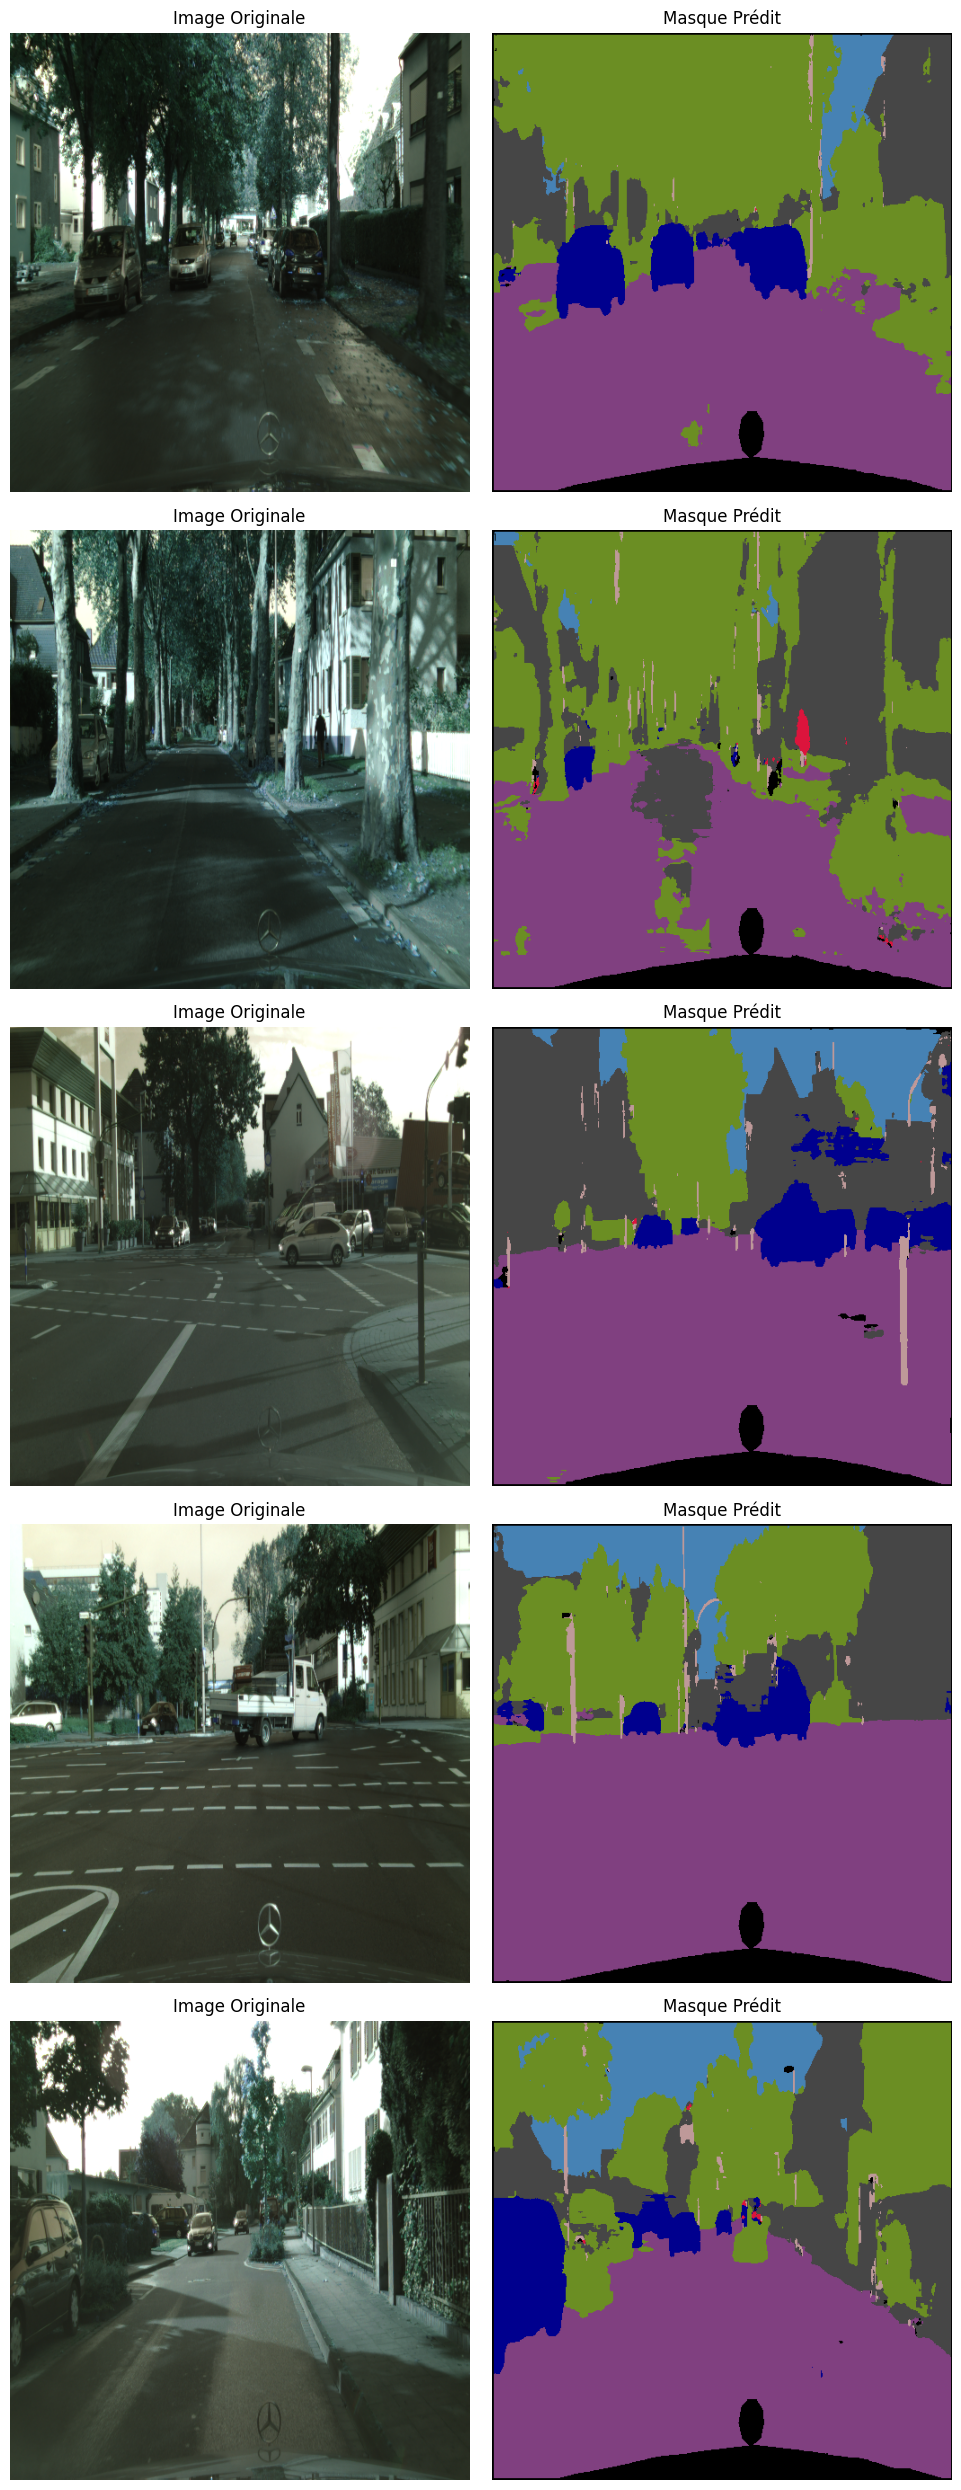

In [ ]:
# Définir une palette de couleurs pour chaque classe
PALETTE = np.array([
    [0, 0, 0],        # void
    [128, 64, 128],   # flat
    [70, 70, 70],     # construction
    [190, 153, 153],  # object
    [107, 142, 35],   # nature
    [70, 130, 180],   # sky
    [220, 20, 60],    # human
    [0, 0, 142]       # vehicle
])

# Convertir les masques en couleur
def convert_mask_to_color(mask):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(8):
        color_mask[mask == i] = PALETTE[i]
    return color_mask

# Visualiser des exemples d'images avec leurs masques correspondants
def visualize_predictions(images, predictions, num_examples=5):
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 5))
    axes = axes.ravel()

    for i in range(num_examples):
        # Charger l'image
        img = images[i]
        pred_mask = convert_mask_to_color(predictions[i])

        # Afficher l'image originale
        axes[2*i].imshow(img)
        axes[2*i].set_title("Image Originale")
        axes[2*i].axis('off')

        # Afficher le masque prédit
        axes[2*i + 1].imshow(pred_mask)
        axes[2*i + 1].set_title("Masque Prédit")
        axes[2*i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualiser les prédictions
visualize_predictions(x_test_SA, predicted_classes, num_examples=5)

### Entrainement d'un SegFormer pré entrainé

Présentation de SegFormer

#### Data generator pour SegFormer

In [17]:
class CityscapesDataset(Dataset):
    CATS = {
        'void': [0, 1, 2, 3, 4, 5, 6],
        'flat': [7, 8, 9, 10],
        'construction': [11, 12, 13, 14, 15, 16],
        'object': [17, 18, 19, 20],
        'nature': [21, 22],
        'sky': [23],
        'human': [24, 25],
        'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
    }

    def __init__(self, image_paths, mask_paths, crop_x, crop_y, image_processor, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.crop_x = crop_x
        self.crop_y = crop_y
        self.image_processor = image_processor
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        img, mask = self._get_image_and_mask(img_path, mask_path)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        # Utiliser le image_processor pour transformer img, sans affecter mask
        inputs = self.image_processor(images=img, return_tensors="pt")
        img = inputs["pixel_values"].squeeze()

        # Convertir le masque en type Long
        mask = torch.tensor(mask, dtype=torch.long)

        return {"pixel_values": img, "labels": mask}

    def _get_image_and_mask(self, img_path, mask_path):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.crop_x, self.crop_y))
        mask = cv2.resize(mask, (self.crop_x, self.crop_y), interpolation=cv2.INTER_NEAREST)
        mask = self._convert_mask(mask)
        return img, mask

    def _convert_mask(self, img):
        mask = np.zeros((img.shape[0], img.shape[1], 8), dtype=np.uint8)
        for i in range(-1, 34):
            if i in self.CATS['void']:
                mask[:, :, 0] = np.logical_or(mask[:, :, 0], (img == i))
            elif i in self.CATS['flat']:
                mask[:, :, 1] = np.logical_or(mask[:, :, 1], (img == i))
            elif i in self.CATS['construction']:
                mask[:, :, 2] = np.logical_or(mask[:, :, 2], (img == i))
            elif i in self.CATS['object']:
                mask[:, :, 3] = np.logical_or(mask[:, :, 3], (img == i))
            elif i in self.CATS['nature']:
                mask[:, :, 4] = np.logical_or(mask[:, :, 4], (img == i))
            elif i in self.CATS['sky']:
                mask[:, :, 5] = np.logical_or(mask[:, :, 5], (img == i))
            elif i in self.CATS['human']:
                mask[:, :, 6] = np.logical_or(mask[:, :, 6], (img == i))
            elif i in self.CATS['vehicle']:
                mask[:, :, 7] = np.logical_or(mask[:, :, 7], (img == i))
        return np.argmax(mask, axis=2).astype('uint8')

# Fonction pour obtenir les chemins des images et des masques
def get_image_and_mask_paths(image_base_dir, mask_base_dir):
    cities = os.listdir(image_base_dir)
    image_paths = []
    mask_paths = []
    for city in cities:
        city_image_dir = os.path.join(image_base_dir, city)
        city_mask_dir = os.path.join(mask_base_dir, city)
        images = os.listdir(city_image_dir)
        for img in images:
            mask = img.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
            mask_path = os.path.join(city_mask_dir, mask)
            if os.path.exists(mask_path):
                image_paths.append(os.path.join(city_image_dir, img))
                mask_paths.append(mask_path)
            else:
                print(f"Mask not found for image: {img}")
    print(f"Total images loaded from {image_base_dir}: {len(image_paths)}")
    print(f"Total masks loaded from {mask_base_dir}: {len(mask_paths)}")
    return image_paths, mask_paths

# Utiliser un modèle SegFormer disponible
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
model_name_nd = "nvidia/segformer-b0-finetuned-cityscapes-1024-1024"

# Initialiser les image_processor de SegFormer
image_processor = SegformerImageProcessor.from_pretrained(model_name)
image_processor_nd = SegformerImageProcessor.from_pretrained(model_name_nd)

# Obtenir les chemins des images et des masques
train_image_paths, train_mask_paths = get_image_and_mask_paths("/content/drive/My Drive/data/leftImg8bit/train", "/content/drive/My Drive/data/gtFine/train")

# Créer les datasets pour l'entraînement
train_dataset = CityscapesDataset(
    image_paths=train_image_paths,
    mask_paths=train_mask_paths,
    crop_x=512,
    crop_y=512,
    image_processor=image_processor
)

# Obtenir les chemins des images et des masques pour la validation
val_image_paths, val_mask_paths = get_image_and_mask_paths("/content/drive/My Drive/data/leftImg8bit/val", "/content/drive/My Drive/data/gtFine/val")

# Créer les datasets pour la validation
val_dataset = CityscapesDataset(
    image_paths=val_image_paths,
    mask_paths=val_mask_paths,
    crop_x=512,
    crop_y=512,
    image_processor=image_processor,
)

# Obtenir les chemins des images et des masques pour le test
test_image_paths, test_mask_paths = get_image_and_mask_paths("/content/drive/My Drive/data/leftImg8bit/test", "/content/drive/My Drive/data/gtFine/test")

# Créer les datasets pour le test
test_dataset = CityscapesDataset(
    image_paths=test_image_paths,
    mask_paths=test_mask_paths,
    crop_x=512,
    crop_y=512,
    image_processor=image_processor,
)

# Pour tester un lot de données de test :
data = test_dataset[0]
x_test = data['pixel_values']
y_test = data['labels']
print(x_test.shape, y_test.shape)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

Total images loaded from /content/drive/My Drive/data/leftImg8bit/train: 2975
Total masks loaded from /content/drive/My Drive/data/gtFine/train: 2975
Total images loaded from /content/drive/My Drive/data/leftImg8bit/val: 500
Total masks loaded from /content/drive/My Drive/data/gtFine/val: 500
Total images loaded from /content/drive/My Drive/data/leftImg8bit/test: 1525
Total masks loaded from /content/drive/My Drive/data/gtFine/test: 1525
torch.Size([3, 512, 512]) torch.Size([512, 512])


#### Data generator avec augmentation pour SegFormer

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
from transformers import SegformerFeatureExtractor
import imgaug.augmenters as iaa
import imgaug as ia

class CityscapesDatasetAugment(Dataset):
    CATS = {
        'void': [0, 1, 2, 3, 4, 5, 6],
        'flat': [7, 8, 9, 10],
        'construction': [11, 12, 13, 14, 15, 16],
        'object': [17, 18, 19, 20],
        'nature': [21, 22],
        'sky': [23],
        'human': [24, 25],
        'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
    }

    def __init__(self, image_paths, mask_paths, crop_x, crop_y, feature_extractor, augment=False, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.crop_x = crop_x
        self.crop_y = crop_y
        self.feature_extractor = feature_extractor
        self.augment = augment
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        img, mask = self._get_image_and_mask(img_path, mask_path)

        if self.augment:
            img, mask = self._augment_data(img, mask)

        inputs = self.feature_extractor(images=img, return_tensors="pt")
        img = inputs["pixel_values"].squeeze()
        mask = torch.tensor(mask, dtype=torch.long)

        return img, mask

    def _augment_data(self, img, mask):
        segmap = ia.SegmentationMapsOnImage(mask, shape=img.shape)
        seq = iaa.Sequential([
            iaa.Affine(rotate=(-10, 10)),
            iaa.GammaContrast((0.5, 2.0)),
            iaa.Fliplr(0.5),
            iaa.CropAndPad(px=(-10, 10)),
            iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))
        ])
        img_aug, segmap_aug = seq(image=img, segmentation_maps=segmap)
        mask_aug = segmap_aug.get_arr()
        return img_aug, mask_aug

    def _get_image_and_mask(self, img_path, mask_path):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.crop_x, self.crop_y))
        mask = cv2.resize(mask, (self.crop_x, self.crop_y), interpolation=cv2.INTER_NEAREST)
        mask = self._convert_mask(mask)
        return img, mask

    def _convert_mask(self, img):
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(-1, 34):
            if i in self.CATS['void']:
                mask[img == i] = 0
            elif i in self.CATS['flat']:
                mask[img == i] = 1
            elif i in self.CATS['construction']:
                mask[img == i] = 2
            elif i in self.CATS['object']:
                mask[img == i] = 3
            elif i in self.CATS['nature']:
                mask[img == i] = 4
            elif i in self.CATS['sky']:
                mask[img == i] = 5
            elif i in self.CATS['human']:
                mask[img == i] = 6
            elif i in self.CATS['vehicle']:
                mask[img == i] = 7
        return mask

# Fonction pour obtenir les chemins des images et des masques
def get_image_and_mask_paths(image_base_dir, mask_base_dir):
    cities = os.listdir(image_base_dir)
    image_paths = []
    mask_paths = []
    for city in cities:
        city_image_dir = os.path.join(image_base_dir, city)
        city_mask_dir = os.path.join(mask_base_dir, city)
        images = os.listdir(city_image_dir)
        for img in images:
            mask = img.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
            mask_path = os.path.join(city_mask_dir, mask)
            if os.path.exists(mask_path):
                image_paths.append(os.path.join(city_image_dir, img))
                mask_paths.append(mask_path)
            else:
                print(f"Mask not found for image: {img}")
    print(f"Total images loaded from {image_base_dir}: {len(image_paths)}")
    print(f"Total masks loaded from {mask_base_dir}: {len(mask_paths)}")
    return image_paths, mask_paths

# Initialiser le feature extractor de SegFormer
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Obtenir les chemins des images et des masques
train_image_paths, train_mask_paths = get_image_and_mask_paths("/content/drive/My Drive/data/leftImg8bit/train", "/content/drive/My Drive/data/gtFine/train")

# Créer les datasets pour l'entraînement avec augmentation
train_dataset_aug = CityscapesDatasetAugment(
    image_paths=train_image_paths,
    mask_paths=train_mask_paths,
    crop_x=512,
    crop_y=512,
    feature_extractor=feature_extractor,
    augment=True
)

# Obtenir les chemins des images et des masques pour la validation
val_image_paths, val_mask_paths = get_image_and_mask_paths("/content/drive/My Drive/data/leftImg8bit/val", "/content/drive/My Drive/data/gtFine/val")

# Obtenir les chemins des images et des masques pour le test
test_image_paths, test_mask_paths = get_image_and_mask_paths("/content/drive/My Drive/data/leftImg8bit/test", "/content/drive/My Drive/data/gtFine/test")

# Créer les datasets pour la validation et le test sans augmentation
val_dataset_aug = CityscapesDatasetAugment(
    image_paths=val_image_paths,
    mask_paths=val_mask_paths,
    crop_x=512,
    crop_y=512,
    feature_extractor=feature_extractor,
    augment=False
)
test_dataset_aug = CityscapesDatasetAugment(
    image_paths=test_image_paths,
    mask_paths=test_mask_paths,
    crop_x=512,
    crop_y=512,
    feature_extractor=feature_extractor,
    augment=False
)

# Créer les DataLoaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=8, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=8, shuffle=False)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=8, shuffle=False)

# Pour tester un lot de données d'entraînement et afficher la forme du masque d'origine :
x_train_seg_aug, y_train_seg_aug = next(iter(train_loader_aug))
print(x_train_seg_aug.shape, y_train_seg_aug.shape)  # Affiche la forme des lots de données générés

# Pour tester un lot de données de validation :
x_val_seg_aug, y_val_seg_aug = next(iter(val_loader_aug))
print(x_val_seg_aug.shape, y_val_seg_aug.shape)  # Affiche la forme des lots de données générés

# Pour tester un lot de données de test :
x_test_seg_aug, y_test_seg_aug = next(iter(test_loader_aug))
print(x_test_seg_aug.shape, y_test_seg_aug.shape)  # Affiche la forme des lots de données générés

Total images loaded from /content/drive/My Drive/data/leftImg8bit/train: 2975
Total masks loaded from /content/drive/My Drive/data/gtFine/train: 2975
Total images loaded from /content/drive/My Drive/data/leftImg8bit/val: 500
Total masks loaded from /content/drive/My Drive/data/gtFine/val: 500
Total images loaded from /content/drive/My Drive/data/leftImg8bit/test: 1525
Total masks loaded from /content/drive/My Drive/data/gtFine/test: 1525
torch.Size([8, 3, 512, 512]) torch.Size([8, 512, 512])
torch.Size([8, 3, 512, 512]) torch.Size([8, 512, 512])
torch.Size([8, 3, 512, 512]) torch.Size([8, 512, 512])


In [ ]:
import os
import numpy as np
from PIL import Image
import cv2
from imgaug import augmenters as iaa
import imgaug as ia
from transformers import SegformerFeatureExtractor
from tensorflow.keras.utils import Sequence

class CityscapesGeneratorAugment(Sequence):
    CATS = {
        'void': [0, 1, 2, 3, 4, 5, 6],
        'flat': [7, 8, 9, 10],
        'construction': [11, 12, 13, 14, 15, 16],
        'object': [17, 18, 19, 20],
        'nature': [21, 22],
        'sky': [23],
        'human': [24, 25],
        'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
    }

    def __init__(self, image_paths, mask_paths, crop_x, crop_y, batch_size, feature_extractor, augment=False, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.crop_x = crop_x
        self.crop_y = crop_y
        self.batch_size = batch_size
        self.feature_extractor = feature_extractor
        self.augment = augment
        self.shuffle = shuffle

        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = [self.image_paths[i] for i in self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_y = [self.mask_paths[i] for i in self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]]
        x, y = self.__load_data(batch_x, batch_y)
        if not x:  # Vérifier si la liste des images est vide
            raise ValueError(f"No images loaded for index {idx}")
        inputs = self.feature_extractor(images=x, return_tensors="tf")
        return inputs["pixel_values"], np.array(y)

    def on_epoch_end(self):
        if self.shuffle:
            self.image_paths, self.mask_paths = self._shuffle_data(self.image_paths, self.mask_paths)
            self.indexes = np.arange(len(self.image_paths))

    def __load_data(self, image_paths, mask_paths):
        images = []
        masks = []
        for img_path, mask_path in zip(image_paths, mask_paths):
            img, mask = self._get_image_and_mask(img_path, mask_path)
            if img is None or mask is None:
                continue  # Ignore les paires d'images/masques invalides
            # Conversion des types de données ici
            img, mask = np.array(img).astype(np.float32) / 255.0, np.array(mask).astype(np.uint8)
            if self.augment:
                img, mask = self._augment_data(img, mask)
                # Assurer que les valeurs de l'image restent dans la plage [0, 1]
                img = np.clip(img, 0, 1)
            images.append(img)
            masks.append(mask)
        return images, masks

    def _augment_data(self, img, mask):
        segmap = ia.SegmentationMapsOnImage(mask, shape=img.shape)
        seq = iaa.Sequential([
            iaa.Affine(rotate=(-10, 10)),
            iaa.GammaContrast((0.5, 2.0)),
            iaa.Fliplr(0.5),
            iaa.CropAndPad(px=(-10, 10)),
            iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))
        ])
        img_aug, segmap_aug = seq(image=img, segmentation_maps=segmap)
        mask_aug = segmap_aug.get_arr()
        return img_aug, mask_aug

    def _shuffle_data(self, image_paths, mask_paths):
        combined = list(zip(image_paths, mask_paths))
        np.random.shuffle(combined)
        if len(combined) > 0:
            image_paths[:], mask_paths[:] = zip(*combined)
        else:
            image_paths, mask_paths = [], []
        return image_paths, mask_paths

    def _get_image_and_mask(self, img_path, mask_path):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.crop_x, self.crop_y))
        mask = cv2.resize(mask, (self.crop_x, self.crop_y), interpolation=cv2.INTER_NEAREST)
        mask = self._convert_mask(mask)
        return img, mask

    def _convert_mask(self, img):
        mask = np.zeros((img.shape[0], img.shape[1], 8), dtype=np.uint8)
        for i in range(-1, 34):
            if i in self.CATS['void']:
                mask[:, :, 0] = np.logical_or(mask[:, :, 0], (img == i))
            elif i in self.CATS['flat']:
                mask[:, :, 1] = np.logical_or(mask[:, :, 1], (img == i))
            elif i in self.CATS['construction']:
                mask[:, :, 2] = np.logical_or(mask[:, :, 2], (img == i))
            elif i in self.CATS['object']:
                mask[:, :, 3] = np.logical_or(mask[:, :, 3], (img == i))
            elif i in self.CATS['nature']:
                mask[:, :, 4] = np.logical_or(mask[:, :, 4], (img == i))
            elif i in self.CATS['sky']:
                mask[:, :, 5] = np.logical_or(mask[:, :, 5], (img == i))
            elif i in self.CATS['human']:
                mask[:, :, 6] = np.logical_or(mask[:, :, 6], (img == i))
            elif i in self.CATS['vehicle']:
                mask[:, :, 7] = np.logical_or(mask[:, :, 7], (img == i))
        return np.argmax(mask, axis=2).astype('uint8')

   # Fonction pour obtenir les chemins des images et des masques
    def get_image_and_mask_paths(image_base_dir, mask_base_dir):
        cities = os.listdir(image_base_dir)
        image_paths = []
        mask_paths = []
        for city in cities:
            city_image_dir = os.path.join(image_base_dir, city)
            city_mask_dir = os.path.join(mask_base_dir, city)
            images = os.listdir(city_image_dir)
            for img in images:
                mask = img.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                mask_path = os.path.join(city_mask_dir, mask)
                if os.path.exists(mask_path):
                    image_paths.append(os.path.join(city_image_dir, img))
                    mask_paths.append(mask_path)
                else:
                    print(f"Mask not found for image: {img}")
        print(f"Total images loaded from {image_base_dir}: {len(image_paths)}")
        print(f"Total masks loaded from {mask_base_dir}: {len(mask_paths)}")
        return image_paths, mask_paths

# Initialiser le feature extractor de SegFormer
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Obtenir les chemins des images et des masques
train_image_paths, train_mask_paths = get_image_and_mask_paths("/content/drive/My Drive/data/leftImg8bit/train", "/content/drive/My Drive/data/gtFine/train")

# Créer les générateurs de données avec augmentation pour l'entraînement
train_generator_aug = CityscapesGeneratorAugment(
    image_paths= train_image_paths,
    mask_paths= train_mask_paths,
    crop_x = 512,
    crop_y = 512,
    batch_size=8,
    feature_extractor=feature_extractor,
    augment=True
)

# Obtenir les chemins des images et des masques pour la validation
val_image_paths, val_mask_paths = get_image_and_mask_paths("/content/drive/My Drive/data/leftImg8bit/val", "/content/drive/My Drive/data/gtFine/val")

# Obtenir les chemins des images et des masques pour le test
test_image_paths, test_mask_paths = get_image_and_mask_paths("/content/drive/My Drive/data/leftImg8bit/test", "/content/drive/My Drive/data/gtFine/test")

# Créer les générateurs de données sans augmentation pour la validation et le test
val_generator_aug = CityscapesGeneratorAugment(
    image_paths= val_image_paths,
    mask_paths=val_mask_paths,
    crop_x = 512,
    crop_y = 512,
    batch_size=8,
    feature_extractor=feature_extractor,
    shuffle=False,
    augment=False
)
test_generator_aug = CityscapesGeneratorAugment(
    image_paths= test_image_paths,
    mask_paths= test_mask_paths,
    crop_x = 512,
    crop_y = 512,
    batch_size=8,
    feature_extractor=feature_extractor,
    shuffle=False,
    augment=False
)

# Pour tester un lot de données d'entraînement et afficher la forme du masque d'origine :
x_train_seg_aug, y_train_seg_aug = train_generator_aug[0]
print(x_train_seg_aug.shape, y_train_seg_aug.shape)  # Affiche la forme des lots de données générés

# Pour tester un lot de données de validation :
x_val_seg_aug, y_val_seg_aug = val_generator_aug[0]
print(x_val_seg_aug.shape, y_val_seg_aug.shape)  # Affiche la forme des lots de données générés

# Pour tester un lot de données de test :
x_test_seg_aug, y_test_seg_aug = test_generator_aug[0]
print(x_test_seg_aug.shape, y_test_seg_aug.shape)  # Affiche la forme des lots de données générés


Total images loaded from /content/drive/My Drive/data/leftImg8bit/train: 2975
Total masks loaded from /content/drive/My Drive/data/gtFine/train: 2975
Total images loaded from /content/drive/My Drive/data/leftImg8bit/val: 500
Total masks loaded from /content/drive/My Drive/data/gtFine/val: 500
Total images loaded from /content/drive/My Drive/data/leftImg8bit/test: 1525
Total masks loaded from /content/drive/My Drive/data/gtFine/test: 1525
(8, 3, 512, 512) (8, 512, 512)
(8, 3, 512, 512) (8, 512, 512)
(8, 3, 512, 512) (8, 512, 512)


#### Entrainement de SegFormer pré entrainé

In [8]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 9.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [9]:
pip install transformers[torch]

version 3


In [ ]:
# Initialiser le modèle avec les poids pré-entraînés
model_nd = SegformerForSemanticSegmentation.from_pretrained(
    model_name_nd,
    num_labels=8,  # Nombre de classes pour votre tâche de segmentation
    ignore_mismatched_sizes=True
)

# Réinitialiser la couche de classification pour correspondre au nombre de classes
model_nd.decode_head.classifier = torch.nn.Conv2d(256, 8, kernel_size=1)
model_nd.decode_head.classifier.bias.data = torch.zeros(8)
model_nd.decode_head.classifier.weight.data = torch.nn.init.kaiming_normal_(torch.empty(8, 256, 1, 1))

# Définir le répertoire de sauvegarde
save_dir = '/content/drive/My Drive/model_segformer'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Assurez-vous que le modèle est sur le GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cpu':
    raise ValueError("A GPU is required for this script.")

model_nd.to(device)

# Fonction de métrique pour l'entraînement
metric = load_metric("mean_iou", trust_remote_code=True)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(1)  # (batch_size, height, width)

    # Convertir les prédictions en tenseurs PyTorch
    preds = torch.tensor(preds, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)

    # Redimensionner les prédictions pour correspondre aux dimensions des labels
    preds = F.interpolate(preds.unsqueeze(1), size=labels.shape[1:], mode='nearest').squeeze(1).long()

    # Assurez-vous que les dimensions correspondent
    labels = labels.squeeze()
    preds = preds.squeeze()

    print(f"Shape of predictions: {preds.shape}")
    print(f"Shape of labels: {labels.shape}")

    # Vérifier si les dimensions correspondent
    if preds.shape != labels.shape:
        raise ValueError(f"Shape mismatch: predictions {preds.shape}, labels {labels.shape}")

    mean_iou = metric.compute(predictions=preds.numpy(), references=labels.numpy(), num_labels=8, ignore_index=255)
    return {
        "mean_iou": mean_iou['mean_iou']
    }

# Configurer les arguments d'entraînement
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    output_dir=save_dir,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="mean_iou",
    save_total_limit=1,
    fp16=True,  # Utiliser la précision mixte
    dataloader_num_workers=12,
    dataloader_pin_memory=True
)

# Initialiser le Trainer avec les callbacks
trainer = Trainer(
    model=model_nd,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Callback pour arrêt anticipé
)

# Entraîner le modèle
trainer.train()

# Sauvegarder le modèle complet
model_nd.save_pretrained(save_dir)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 256, 1, 1]) in the checkpoint and torch.Size([8, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


In [ ]:
# Initialiser le modèle avec les poids pré-entraînés
model = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    num_labels=8,  # Nombre de classes pour votre tâche de segmentation
    ignore_mismatched_sizes=True
)

# Réinitialiser la couche de classification pour correspondre au nombre de classes
model.decode_head.classifier = torch.nn.Conv2d(256, 8, kernel_size=1)
model.decode_head.classifier.bias.data = torch.zeros(8)
model.decode_head.classifier.weight.data = torch.nn.init.kaiming_normal_(torch.empty(8, 256, 1, 1))

# Définir le répertoire de sauvegarde
save_dir = '/content/drive/My Drive/models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Assurez-vous que le modèle est sur le GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cpu':
    raise ValueError("A GPU is required for this script.")

model.to(device)

# Fonction de métrique pour l'entraînement
metric = load_metric("mean_iou", trust_remote_code=True)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(1)  # (batch_size, height, width)

    # Convertir les prédictions en tenseurs PyTorch
    preds = torch.tensor(preds, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)

    # Redimensionner les prédictions pour correspondre aux dimensions des labels
    preds = F.interpolate(preds.unsqueeze(1), size=labels.shape[1:], mode='nearest').squeeze(1).long()

    # Assurez-vous que les dimensions correspondent
    labels = labels.squeeze()
    preds = preds.squeeze()

    print(f"Shape of predictions: {preds.shape}")
    print(f"Shape of labels: {labels.shape}")

    # Vérifier si les dimensions correspondent
    if preds.shape != labels.shape:
        raise ValueError(f"Shape mismatch: predictions {preds.shape}, labels {labels.shape}")

    mean_iou = metric.compute(predictions=preds.numpy(), references=labels.numpy(), num_labels=8, ignore_index=255)
    return {
        "mean_iou": mean_iou['mean_iou']
    }

# Configurer les arguments d'entraînement
training_args = TrainingArguments(
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    output_dir=save_dir,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="mean_iou",
    save_total_limit=1,
    fp16=True,  # Utiliser la précision mixte
    dataloader_num_workers=16,
    dataloader_pin_memory=True
)

# Initialiser le Trainer avec les callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Callback pour arrêt anticipé
)

# Entraîner le modèle
trainer.train()

# Sauvegarder le modèle complet
model.save_pretrained(save_dir)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([8]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([8, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slow

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Shape of predictions: torch.Size([500, 512, 512])
Shape of labels: torch.Size([500, 512, 512])


### Inférences SegFormer

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


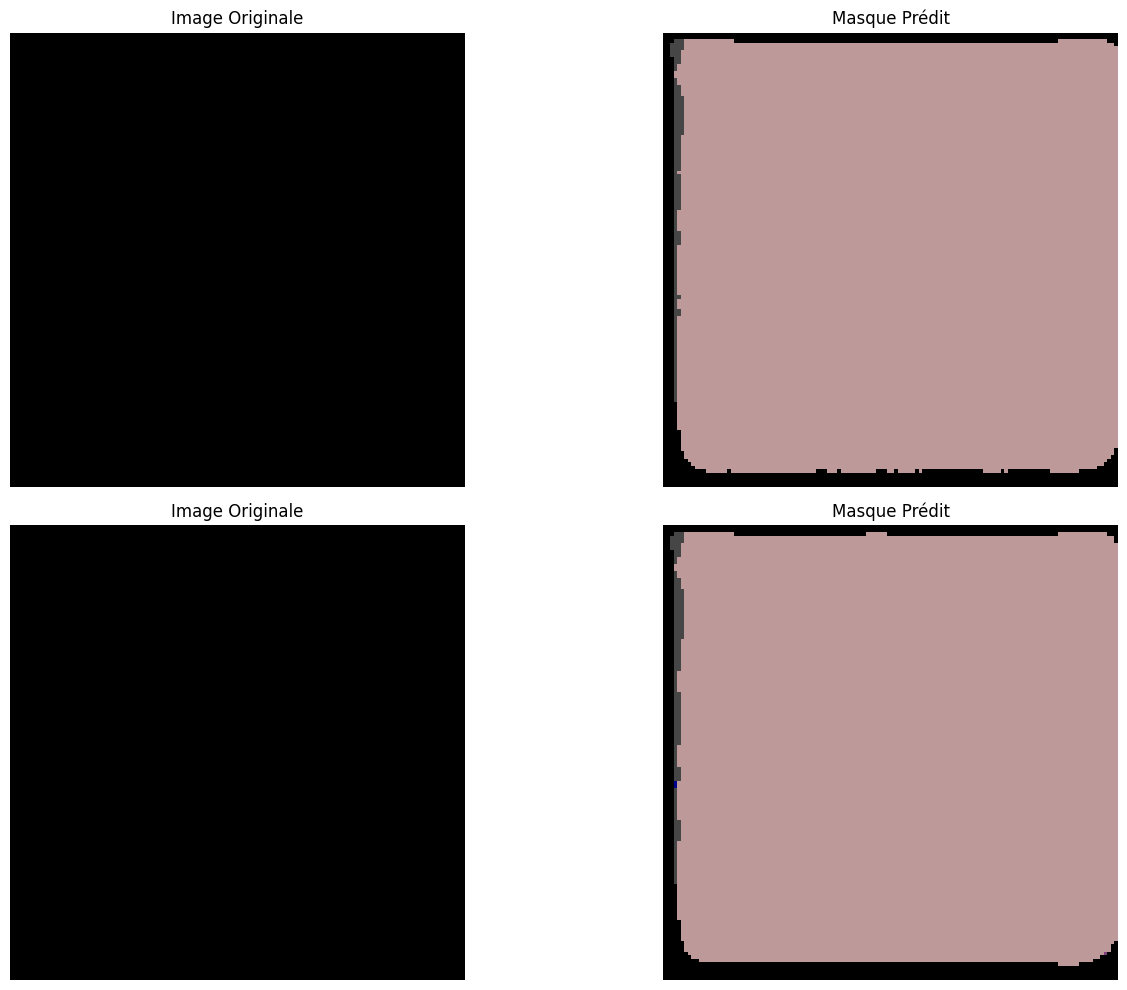

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
from torch.nn import functional as F
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# Définir la palette de couleurs pour les classes
PALETTE = np.array([
    [0, 0, 0],        # void : Noir
    [128, 64, 128],   # flat : Violet
    [70, 70, 70],     # construction : Gris foncé
    [190, 153, 153],  # object : Rose clair
    [107, 142, 35],   # nature : Vert
    [70, 130, 180],   # sky : Bleu ciel
    [220, 20, 60],    # human : Rouge
    [0, 0, 142]       # vehicle : Bleu foncé
])

def convert_mask_to_color(mask):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(8):
        color_mask[mask == i, :] = PALETTE[i]
    return color_mask

def preprocess_image(image_bytes):
    nparr = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError("Cannot decode image, check input format!")
    img = cv2.resize(img, (512, 512))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Charger le modèle sauvegardé
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
model = SegformerForSemanticSegmentation.from_pretrained('/content/drive/My Drive/models')
image_processor = SegformerImageProcessor.from_pretrained(model_name)

# Assurez-vous que le modèle est sur le GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Charger les chemins des images de test
test_image_paths = ['/content/drive/My Drive/data/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png', '/content/drive/My Drive/data/leftImg8bit/test/berlin/berlin_000004_000019_leftImg8bit.png']

# Charger les images de test et prétraiter
preprocessed_images = []
for img_path in test_image_paths[:5]:  # Limiter à 5 images pour la visualisation
    with open(img_path, 'rb') as f:
        image_bytes = f.read()
        image = preprocess_image(image_bytes)
        inputs = image_processor(images=image, return_tensors="pt")
        preprocessed_images.append(inputs["pixel_values"].squeeze(0))
x_test = torch.stack(preprocessed_images).to(device)

def predict(model, x_test):
    with torch.no_grad():  # Désactiver le calcul de gradient pour l'inférence
        logits = model(x_test)  # Assurez-vous que les images sont sur le bon appareil
        probs = F.softmax(logits.logits, dim=1)
        masks = torch.argmax(probs, dim=1)
    return masks

masks = predict(model, x_test)

def visualize_predictions(images, predictions, num_examples=5):
    fig, axes = plt.subplots(num_examples, 2, figsize=(15, num_examples * 5))
    axes = axes.ravel()
    for i in range(num_examples):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        pred_mask = convert_mask_to_color(predictions[i].cpu().numpy())
        axes[2*i].imshow(img)
        axes[2*i].set_title("Image Originale")
        axes[2*i].axis('off')
        axes[2*i + 1].imshow(pred_mask)
        axes[2*i + 1].set_title("Masque Prédit")
        axes[2*i + 1].axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(x_test, masks, num_examples=len(test_image_paths))

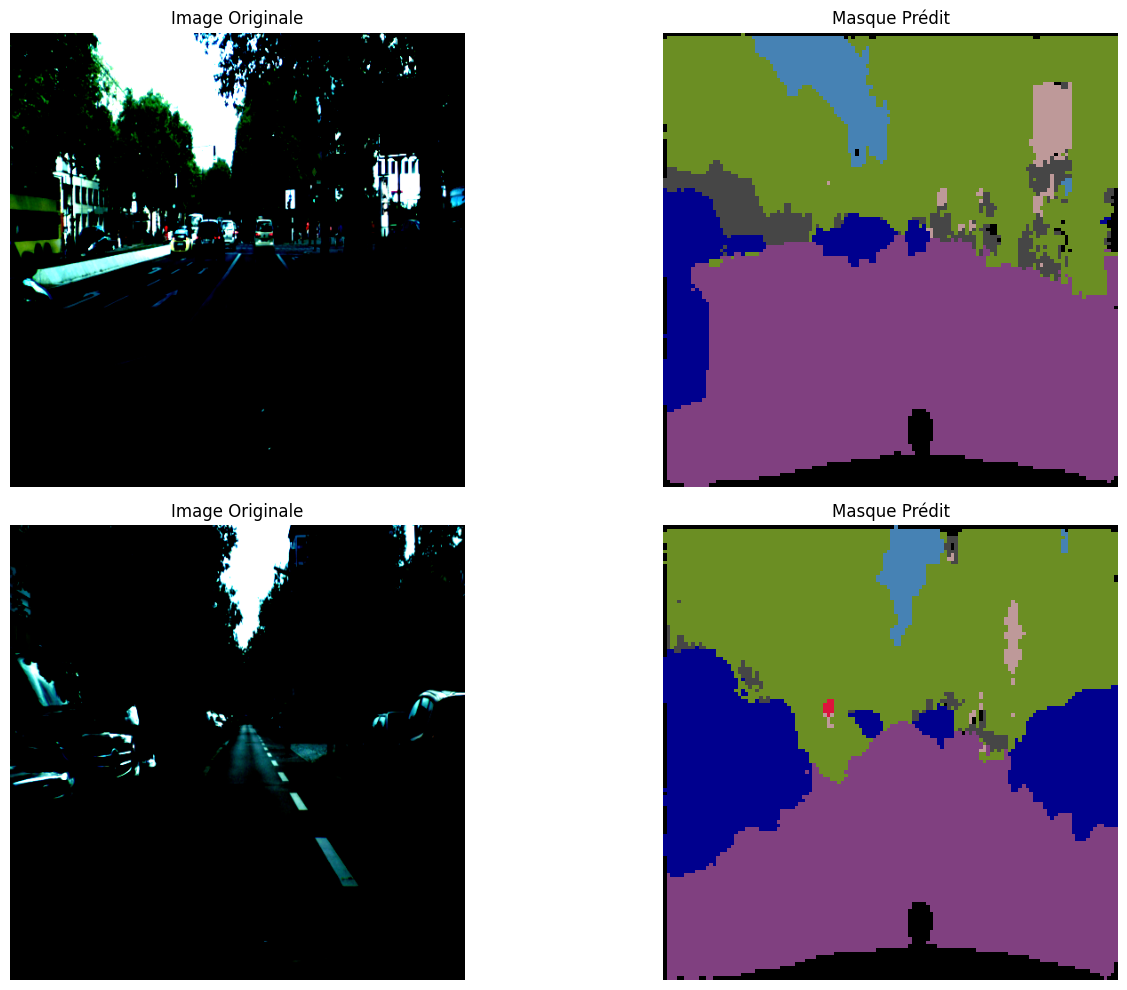

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
from torch.nn import functional as F
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# Définir la palette de couleurs pour les classes
PALETTE = np.array([
    [0, 0, 0],        # void : Noir
    [128, 64, 128],   # flat : Violet
    [70, 70, 70],     # construction : Gris foncé
    [190, 153, 153],  # object : Rose clair
    [107, 142, 35],   # nature : Vert
    [70, 130, 180],   # sky : Bleu ciel
    [220, 20, 60],    # human : Rouge
    [0, 0, 142]       # vehicle : Bleu foncé
])

def convert_mask_to_color(mask):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(8):
        color_mask[mask == i, :] = PALETTE[i]
    return color_mask

# Charger le modèle sauvegardé
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
model = SegformerForSemanticSegmentation.from_pretrained('/content/drive/My Drive/models')
image_processor = SegformerImageProcessor.from_pretrained(model_name)

# Assurez-vous que le modèle est sur le GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Charger les chemins des images de test
# Simuler une fonction pour charger les chemins d'images
test_image_paths = ['/content/drive/My Drive/data/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png', '/content/drive/My Drive/data/leftImg8bit/test/berlin/berlin_000004_000019_leftImg8bit.png']

# Charger les images de test et prétraiter
def preprocess_image(image_bytes):
    nparr = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    size_x, size_y = img.shape[1], img.shape[0]
    img = cv2.resize(img, (512, 512))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img, size_x, size_y

def predict(model, x_test):
    with torch.no_grad():  # Désactiver le calcul de gradient pour l'inférence
        logits = model(x_test)  # Assurez-vous que les images sont sur le bon appareil
        probs = F.softmax(logits.logits, dim=1)
        masks = torch.argmax(probs, dim=1)
    return masks

# Utilisation de la fonction
masks = predict(model, x_test)

def visualize_predictions(images, predictions, num_examples=5):
    fig, axes = plt.subplots(num_examples, 2, figsize=(15, num_examples * 5))
    axes = axes.ravel()

    for i in range(num_examples):
        # Charger l'image
        img = images[i].cpu().permute(1, 2, 0).numpy()
        pred_mask = convert_mask_to_color(predictions[i].cpu().numpy())

        # Afficher l'image originale
        axes[2*i].imshow(img)
        axes[2*i].set_title("Image Originale")
        axes[2*i].axis('off')

        # Afficher le masque prédit
        axes[2*i + 1].imshow(pred_mask)
        axes[2*i + 1].set_title("Masque Prédit")
        axes[2*i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualiser des exemples d'images avec leurs masques correspondants
visualize_predictions(x_test, masks, num_examples=len(test_image_paths))

Total images loaded from /content/drive/My Drive/data/leftImg8bit/test: 1525
Total masks loaded from /content/drive/My Drive/data/gtFine/test: 1525


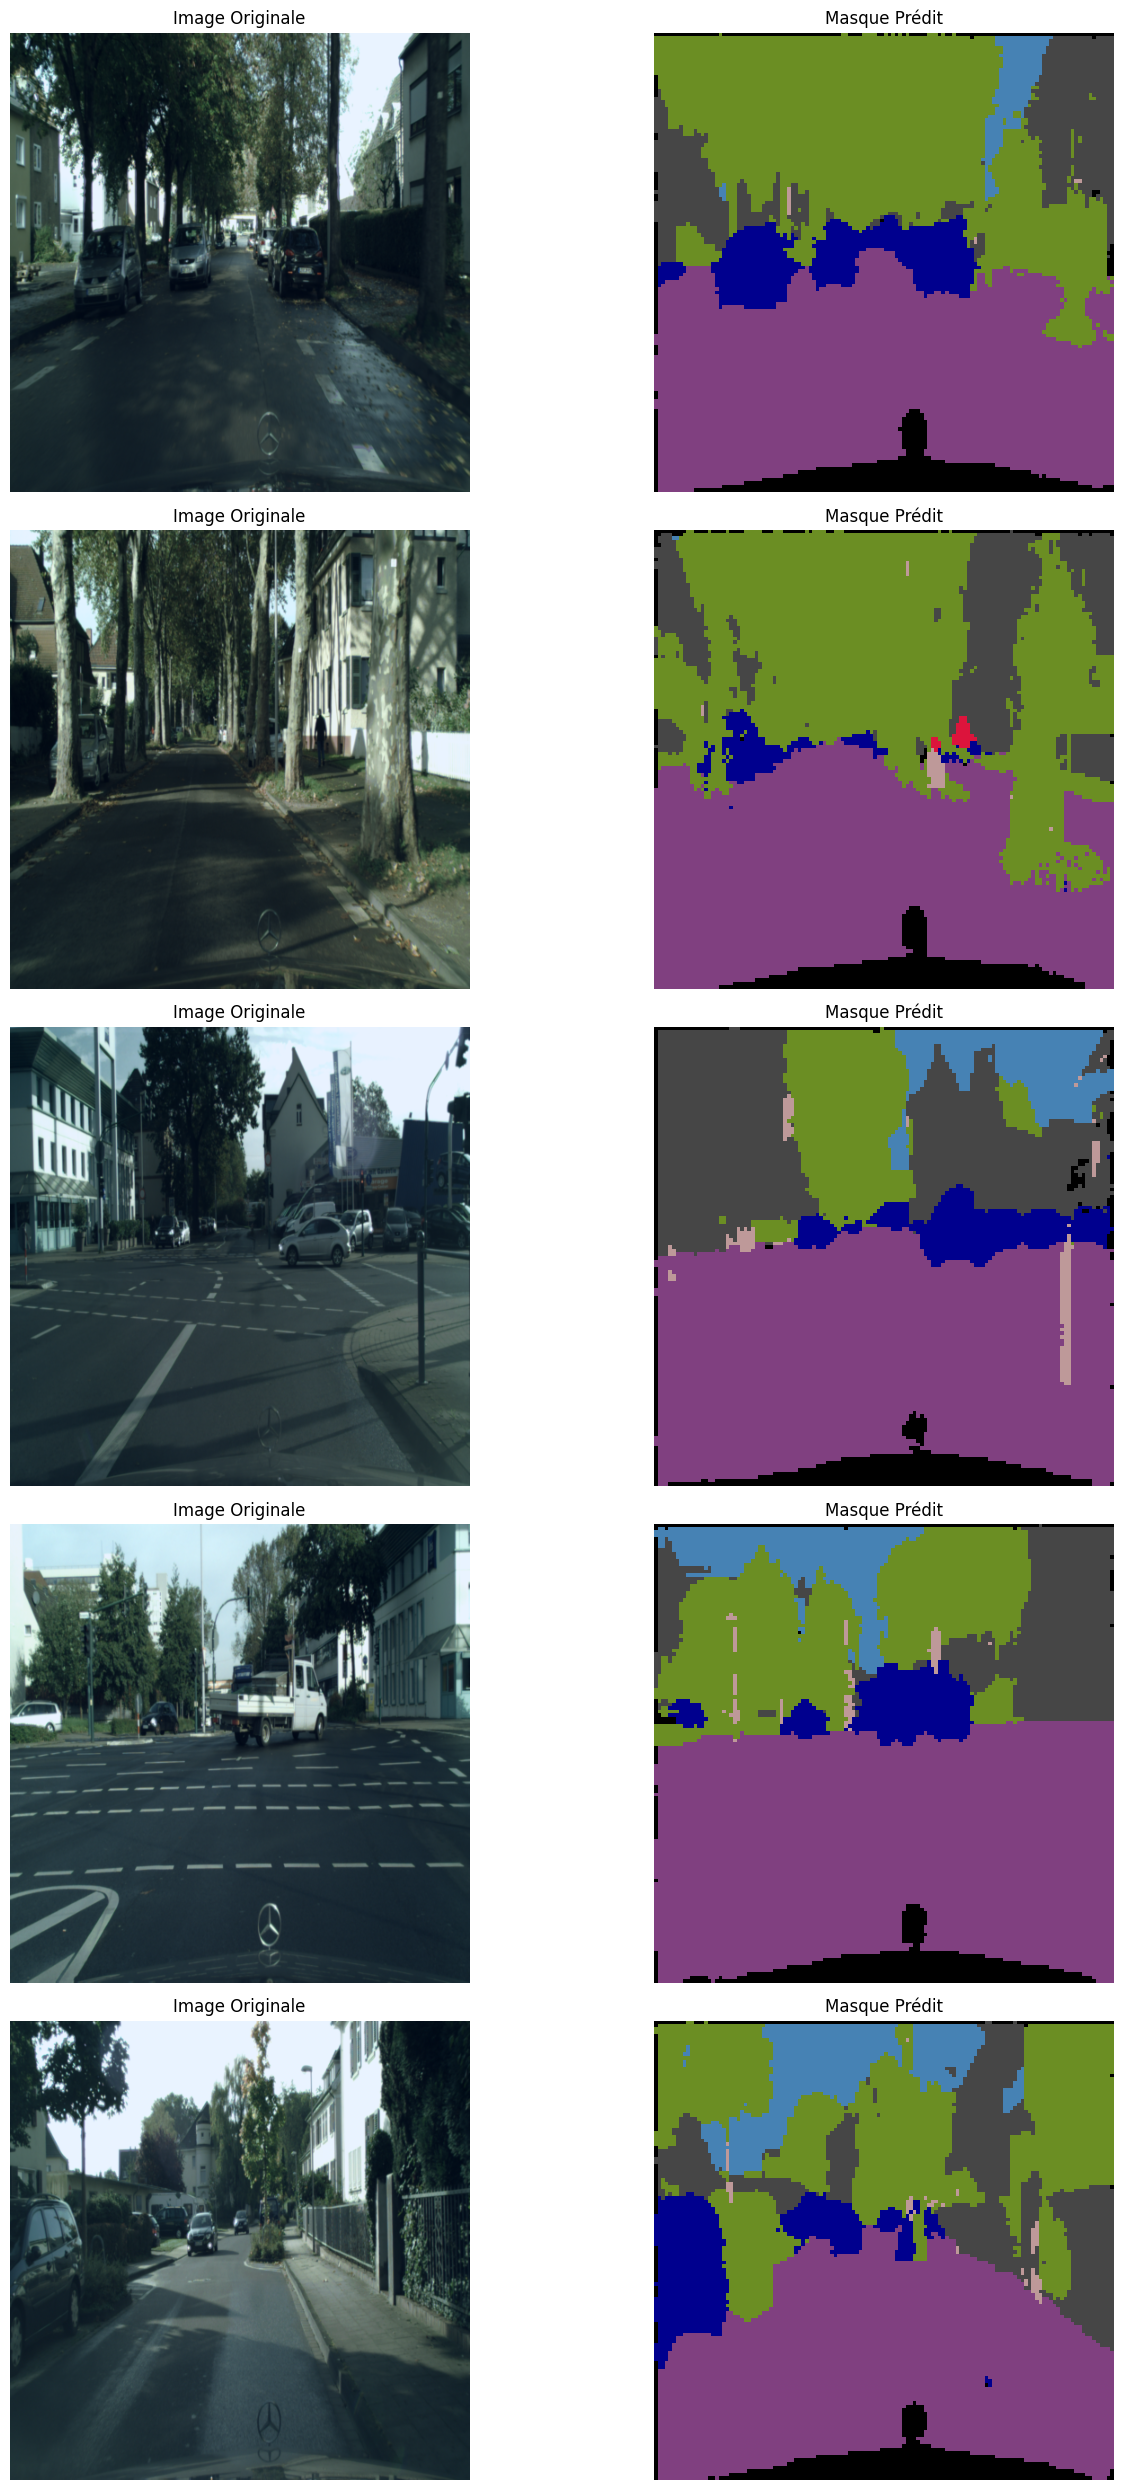

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
from torch.nn import functional as F
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# Définir la palette de couleurs pour les classes
PALETTE = np.array([
    [0, 0, 0],        # void : Noir
    [128, 64, 128],   # flat : Violet
    [70, 70, 70],     # construction : Gris foncé
    [190, 153, 153],  # object : Rose clair
    [107, 142, 35],   # nature : Vert
    [70, 130, 180],   # sky : Bleu ciel
    [220, 20, 60],    # human : Rouge
    [0, 0, 142]       # vehicle : Bleu foncé
])

def convert_mask_to_color(mask):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(8):
        color_mask[mask == i, :] = PALETTE[i]
    return color_mask

# Charger le modèle sauvegardé
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
model = SegformerForSemanticSegmentation.from_pretrained('/content/drive/My Drive/models')
image_processor = SegformerImageProcessor.from_pretrained(model_name)

# Assurez-vous que le modèle est sur le GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Charger les chemins des images de test
test_image_base_dir = '/content/drive/My Drive/data/leftImg8bit/test'
test_mask_base_dir = '/content/drive/My Drive/data/gtFine/test'
test_image_paths, _ = get_image_and_mask_paths(test_image_base_dir, test_mask_base_dir)

# Charger les images de test et prétraiter
preprocessed_images = []
for img_path in test_image_paths[:5]:  # Limiter à 5 images pour la visualisation
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    inputs = image_processor(images=image, return_tensors="pt")
    preprocessed_images.append(inputs["pixel_values"].squeeze(0))
x_test = torch.stack(preprocessed_images).to(device)

# Effectuer des inférences
with torch.no_grad():
    logits = model(x_test)
    # Redimensionner les prédictions pour correspondre à la résolution d'origine
    probs = F.softmax(logits.logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu()

def visualize_predictions(images, predictions, num_examples=5):
    fig, axes = plt.subplots(num_examples, 2, figsize=(15, num_examples * 5))
    axes = axes.ravel()

    for i in range(num_examples):
        # Charger l'image
        img = images[i].cpu().numpy()  # Assurez-vous que les images sont transférées sur le CPU
        img = img.transpose(1, 2, 0)   # Convertir de CxHxW à HxWxC pour la visualisation
        img = (img - img.min()) / (img.max() - img.min())  # Normalisation pour affichage
        pred_mask = convert_mask_to_color(predictions[i].cpu().numpy())  # Transférer les prédictions sur le CPU et convertir

        # Afficher l'image originale
        axes[2*i].imshow(img)
        axes[2*i].set_title("Image Originale")
        axes[2*i].axis('off')

        # Afficher le masque prédit
        axes[2*i + 1].imshow(pred_mask)
        axes[2*i + 1].set_title("Masque Prédit")
        axes[2*i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualiser des exemples d'images avec leurs masques correspondants
visualize_predictions(x_test, preds, num_examples=5)


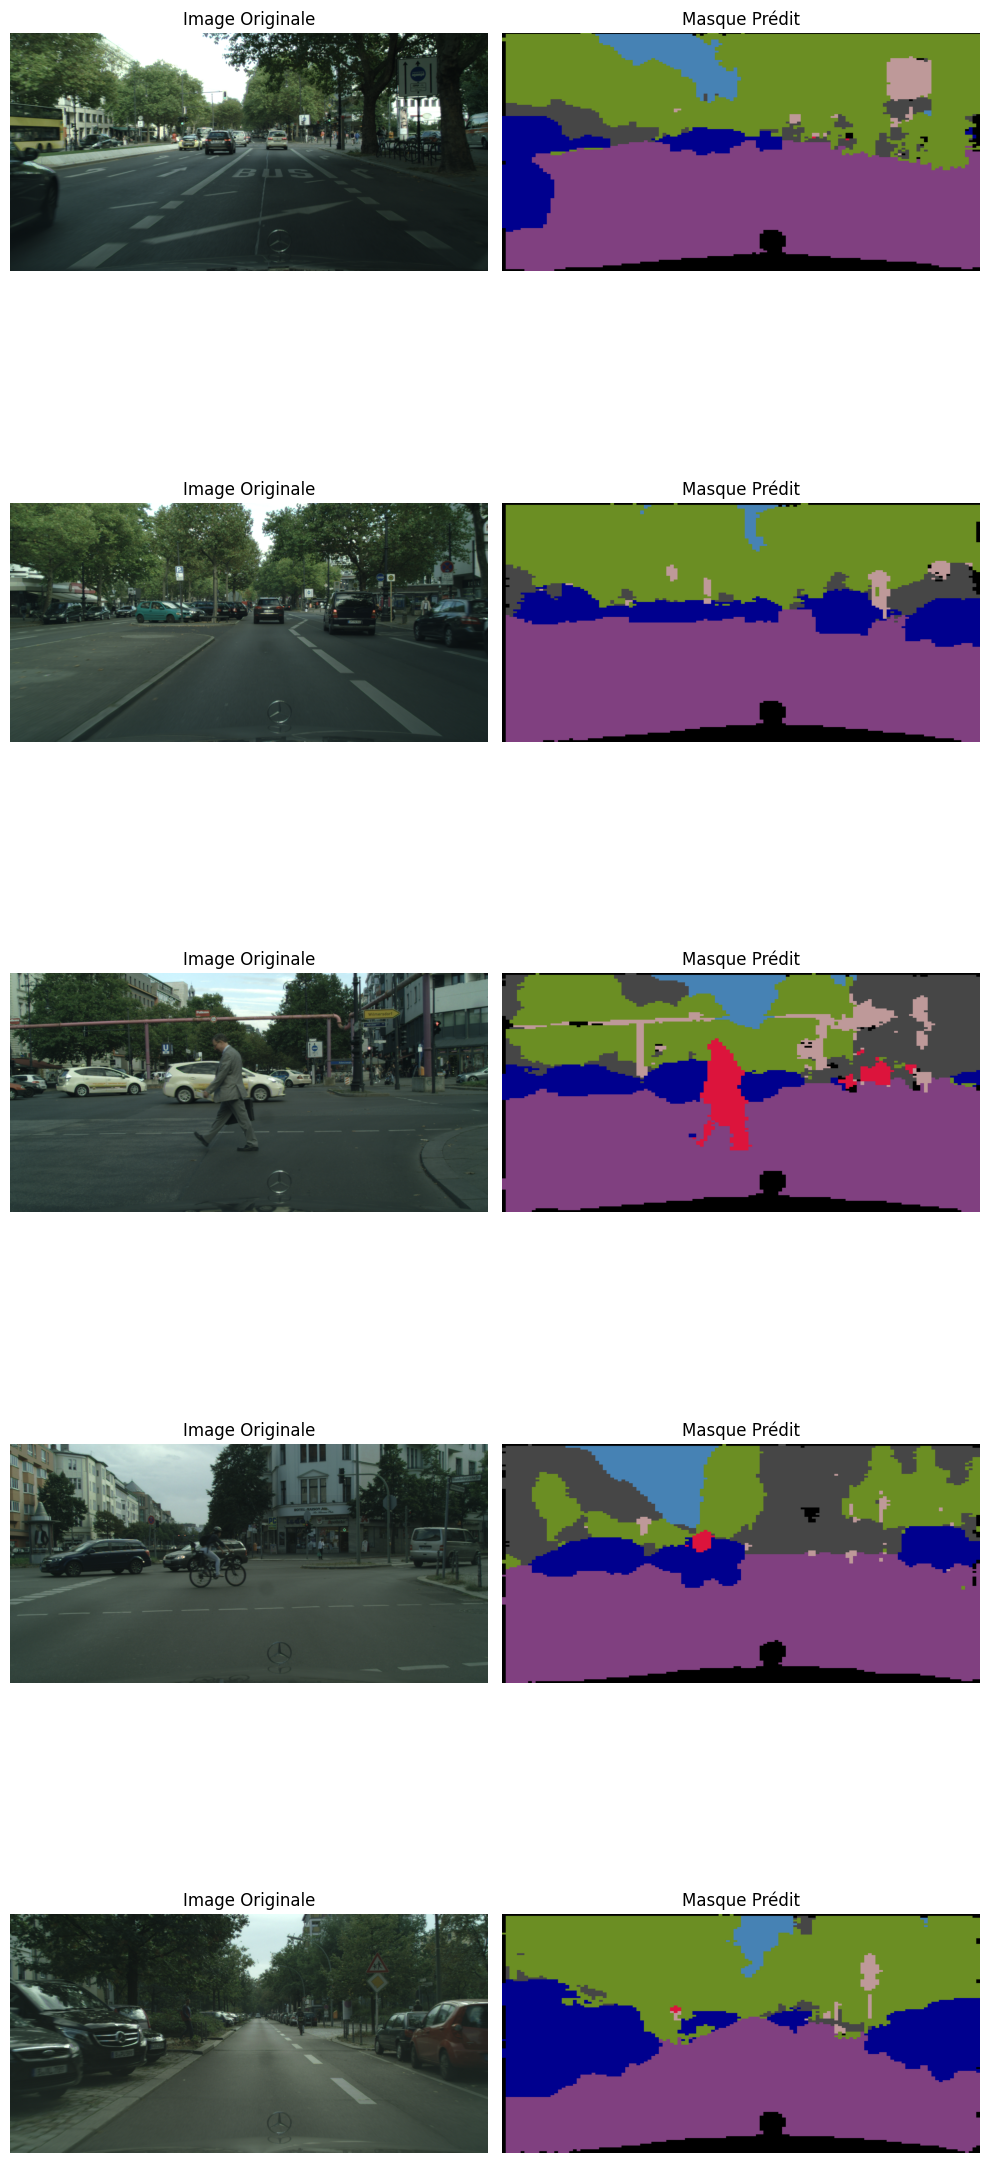

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image

# Définir la palette de couleurs pour les classes
PALETTE = np.array([
    [0, 0, 0],        # void
    [128, 64, 128],   # flat
    [70, 70, 70],     # construction
    [190, 153, 153],  # object
    [107, 142, 35],   # nature
    [70, 130, 180],   # sky
    [220, 20, 60],    # human
    [0, 0, 142]       # vehicle
])

# Convertir les masques en couleur
def convert_mask_to_color(mask):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(8):
        color_mask[mask == i] = PALETTE[i]
    return color_mask

# Charger le modèle sauvegardé
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
model = SegformerForSemanticSegmentation.from_pretrained('/content/drive/My Drive/models')
image_processor = SegformerImageProcessor.from_pretrained(model_name)

# Assurez-vous que le modèle est sur le GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Fonction pour obtenir les chemins des images
def get_image_paths(image_base_dir, num_samples=5):
    cities = os.listdir(image_base_dir)  # Liste des sous-répertoires (villes)
    image_paths = []
    for city in cities:
        city_image_dir = os.path.join(image_base_dir, city)  # Chemin du répertoire d'images de la ville
        images = os.listdir(city_image_dir)  # Liste des fichiers d'images
        for img in images:
            if img.endswith('_leftImg8bit.png'):  # Vérifier l'extension du fichier
                image_paths.append(os.path.join(city_image_dir, img))  # Ajout du chemin de l'image à la liste
    image_paths = sorted(image_paths)[:num_samples]  # Sélectionner le nombre d'échantillons requis
    return image_paths

# Fonction pour prétraiter une image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image_processor(images=image, return_tensors="pt")["pixel_values"].squeeze()
    return image

# Chemin vers les images
image_base_dir = '/content/drive/My Drive/data/leftImg8bit/test'

# Charger les images
num_samples = 5
image_paths = get_image_paths(image_base_dir, num_samples)

# Prétraiter les images de test
preprocessed_images = torch.stack([preprocess_image(img_path) for img_path in image_paths]).to(device)

# Effectuer des prédictions
with torch.no_grad():
    outputs = model(pixel_values=preprocessed_images)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()

# Redimensionner les prédictions pour correspondre à la taille d'origine
def resize_predictions(predictions, image_paths):
    resized_preds = []
    for i, pred in enumerate(predictions):
        original_image = Image.open(image_paths[i])
        original_size = original_image.size
        pred_resized = torch.nn.functional.interpolate(
            torch.tensor(pred).unsqueeze(0).unsqueeze(0).float(),
            size=original_size[::-1],
            mode='nearest'
        ).squeeze().long().numpy()
        resized_preds.append(pred_resized)
    return resized_preds

# Redimensionner les prédictions
resized_preds = resize_predictions(preds, image_paths)

# Visualiser des exemples d'images avec leurs masques correspondants
def visualize_predictions(image_paths, predictions, num_examples=5):
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 5))
    axes = axes.ravel()

    for i in range(num_examples):
        # Charger et convertir l'image en format affichable
        img = np.array(Image.open(image_paths[i]).convert('RGB'))
        pred_mask = convert_mask_to_color(predictions[i])

        # Afficher l'image originale
        axes[2*i].imshow(img)
        axes[2*i].set_title("Image Originale")
        axes[2*i].axis('off')

        # Afficher le masque prédit
        axes[2*i + 1].imshow(pred_mask)
        axes[2*i + 1].set_title("Masque Prédit")
        axes[2*i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualiser les prédictions
visualize_predictions(image_paths, resized_preds, num_examples=num_samples)


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import cv2
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

class SegFormerDataset(Dataset):
    CATS = {
        'void': [0, 1, 2, 3, 4, 5, 6],
        'flat': [7, 8, 9, 10],
        'construction': [11, 12, 13, 14, 15, 16],
        'object': [17, 18, 19, 20],
        'nature': [21, 22],
        'sky': [23],
        'human': [24, 25],
        'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
    }

    def __init__(self, image_paths, mask_paths, crop_x, crop_y, image_processor):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.crop_x = crop_x
        self.crop_y = crop_y
        self.image_processor = image_processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        img, mask = self._get_image_and_mask(img_path, mask_path)

        inputs = self.image_processor(images=img, return_tensors="pt")
        img = inputs["pixel_values"].squeeze()

        mask = torch.tensor(mask, dtype=torch.long)
        return {"pixel_values": img, "labels": mask}

    def _get_image_and_mask(self, img_path, mask_path):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.crop_x, self.crop_y))
        mask = cv2.resize(mask, (self.crop_x, self.crop_y), interpolation=cv2.INTER_NEAREST)
        mask = self._convert_mask(mask)
        return img, mask

    def _convert_mask(self, img):
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(-1, 34):
            if i in self.CATS['void']:
                mask[img == i] = 0
            elif i in self.CATS['flat']:
                mask[img == i] = 1
            elif i in self.CATS['construction']:
                mask[img == i] = 2
            elif i in self.CATS['object']:
                mask[img == i] = 3
            elif i in self.CATS['nature']:
                mask[img == i] = 4
            elif i in self.CATS['sky']:
                mask[img == i] = 5
            elif i in self.CATS['human']:
                mask[img == i] = 6
            elif i in self.CATS['vehicle']:
                mask[img == i] = 7
        return mask

# Fonction pour obtenir les chemins des images et des masques
def get_image_and_mask_paths(image_base_dir, mask_base_dir):
    cities = os.listdir(image_base_dir)
    image_paths = []
    mask_paths = []
    for city in cities:
        city_image_dir = os.path.join(image_base_dir, city)
        city_mask_dir = os.path.join(mask_base_dir, city)
        images = os.listdir(city_image_dir)
        for img in images:
            mask = img.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
            mask_path = os.path.join(city_mask_dir, mask)
            if os.path.exists(mask_path):
                image_paths.append(os.path.join(city_image_dir, img))
                mask_paths.append(mask_path)
            else:
                print(f"Mask not found for image: {img}")
    print(f"Total images loaded from {image_base_dir}: {len(image_paths)}")
    print(f"Total masks loaded from {mask_base_dir}: {len(mask_paths)}")
    return image_paths, mask_paths

# Initialiser le SegformerImageProcessor
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
image_processor = SegformerImageProcessor.from_pretrained(model_name)

# Obtenir les chemins pour l'entraînement
train_image_base_dir = '/content/drive/My Drive/data/leftImg8bit/train'
train_mask_base_dir = '/content/drive/My Drive/data/gtFine/train'
train_image_paths, train_mask_paths = get_image_and_mask_paths(train_image_base_dir, train_mask_base_dir)

# Obtenir les chemins pour la validation
val_image_base_dir = '/content/drive/My Drive/data/leftImg8bit/val'
val_mask_base_dir = '/content/drive/My Drive/data/gtFine/val'
val_image_paths, val_mask_paths = get_image_and_mask_paths(val_image_base_dir, val_mask_base_dir)

# Obtenir les chemins pour le test
test_image_base_dir = '/content/drive/My Drive/data/leftImg8bit/test'
test_mask_base_dir = '/content/drive/My Drive/data/gtFine/test'
test_image_paths, test_mask_paths = get_image_and_mask_paths(test_image_base_dir, test_mask_base_dir)

# Création des datasets
train_dataset = SegFormerDataset(train_image_paths, train_mask_paths, crop_x=512, crop_y=512, image_processor=image_processor)
val_dataset = SegFormerDataset(val_image_paths, val_mask_paths, crop_x=512, crop_y=512, image_processor=image_processor)
test_dataset = SegFormerDataset(test_image_paths, test_mask_paths, crop_x=512, crop_y=512, image_processor=image_processor)

print(f"Total images in train_dataset: {len(train_dataset)}")
print(f"Total images in val_dataset: {len(val_dataset)}")
print(f"Total images in test_dataset: {len(test_dataset)}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


Total images loaded from /content/drive/My Drive/data/leftImg8bit/train: 2975
Total masks loaded from /content/drive/My Drive/data/gtFine/train: 2975
Total images loaded from /content/drive/My Drive/data/leftImg8bit/val: 500
Total masks loaded from /content/drive/My Drive/data/gtFine/val: 500
Total images loaded from /content/drive/My Drive/data/leftImg8bit/test: 1525
Total masks loaded from /content/drive/My Drive/data/gtFine/test: 1525
Total images in train_dataset: 2975
Total images in val_dataset: 500
Total images in test_dataset: 1525


In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import load_metric

# Initialiser le modèle SegFormer
model = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    num_labels=8,  # Nombre de classes pour votre tâche de segmentation
    ignore_mismatched_sizes=True
)

# Réinitialiser la couche de classification pour correspondre au nombre de classes
model.decode_head.classifier = torch.nn.Conv2d(256, 8, kernel_size=1)
model.decode_head.classifier.bias.data = torch.zeros(8)
model.decode_head.classifier.weight.data = torch.nn.init.kaiming_normal_(torch.empty(8, 256, 1, 1))

# Définir le répertoire de sauvegarde
save_dir = '/content/drive/My Drive/models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Assurez-vous que le modèle est sur le GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cpu':
    raise ValueError("A GPU is required for this script.")

model.to(device)

# Fonction de métrique pour l'entraînement
metric = load_metric("mean_iou")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    labels = labels.squeeze()
    preds = preds.squeeze()
    mean_iou = metric.compute(predictions=preds, references=labels, num_labels=8, ignore_index=255)
    return {"mean_iou": mean_iou['mean_iou']}

# Configurer les arguments d'entraînement
training_args = TrainingArguments(
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    output_dir=save_dir,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="mean_iou",
    save_total_limit=2,
    fp16=True,
    dataloader_num_workers=4,
    dataloader_pin_memory=True
)

# Initialiser le Trainer avec les callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Entraîner le modèle
trainer.train()

# Sauvegarder le modèle complet
model.save_pretrained(save_dir)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([8]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([8, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for mean_iou contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/mean_iou/mean_iou.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 8 but corresponding boolean dimension is 512